In [85]:
import alpaca_trade_api as tradeapi
import pandas as pd
from datetime import datetime, timedelta

In [86]:
APCA_API_KEY_ID = 'PKA0XDHFOR2QBKHE7Y7L'
APCA_API_SECRET_KEY = 'r37925RNYTZFUpGewDxaxC1fHwdjHohUojdWBJ0e'
APCA_API_BASE_URL = 'https://paper-api.alpaca.markets'

In [121]:
from alpaca_trade_api.rest import REST, TimeFrame
api = tradeapi.REST(APCA_API_KEY_ID, APCA_API_SECRET_KEY)

# get user info
symbols = input("Enter ONLY Two Stock Symbols (separated by space): ").split(' ')
days_ago_start = input("Enter the Number of Trading Days Ago to Start Stock Data: ")
days_ago_end = input("Enter the Number of Trading Days Ago to End Stock Data (>0): ")

trades_df = pd.DataFrame()
start_date = (datetime.now() - timedelta(days=int(days_ago_start))).strftime("%Y-%m-%d")
end_date = (datetime.now() - timedelta(days=int(days_ago_end))).strftime("%Y-%m-%d")

for symbol in symbols:
    # get data for each stock
    bars_df = api.get_bars(symbol, TimeFrame.Day, start_date, end_date, adjustment='all').df
    # calculate daily percentage change for each stock
    trades_df[symbol] = bars_df["open"]
    
trades_df = trades_df.reset_index()
trades_df['split'] = abs(trades_df[symbols[0]] - trades_df[symbols[1]])
trades_df.drop(columns=[symbols[0], symbols[1], 'timestamp'], inplace=True)
trades_df

Enter ONLY Two Stock Symbols (separated by space): TSLA BHP
Enter the Number of Trading Days Ago to Start Stock Data: 500
Enter the Number of Trading Days Ago to End Stock Data (>0): 1


,split
0,210.110
1,206.150
2,228.110
3,243.560
4,240.380
...,...
339,137.080
340,133.760
341,136.175
342,132.430


<AxesSubplot:>

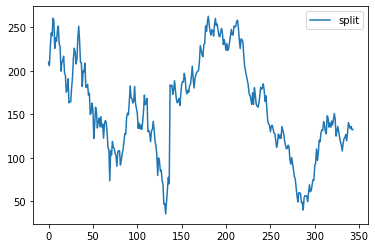

In [123]:
trades_df.plot()

In [124]:
msk = (trades_df.index < len(trades_df)-30)
trades_df_train = trades_df[msk].copy()
trades_df_test = trades_df[~msk].copy()

# ACF Plot and PACF Plot

C:\Users\Ray Li\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


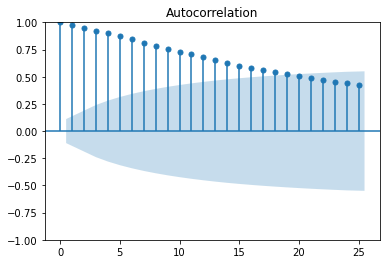

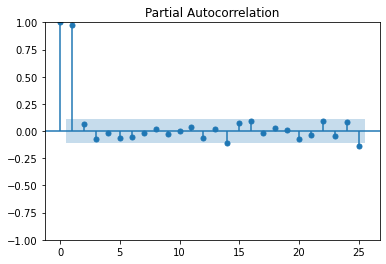

In [125]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(trades_df_train)
pacf = plot_pacf(trades_df_train)

# ADF Test

In [126]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(trades_df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.2775960212835248


# Make Data Stationary by Differencing

<AxesSubplot:>

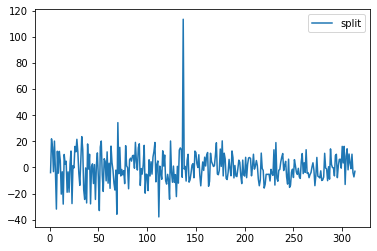

In [127]:
trades_df_train_diff = trades_df_train.diff().dropna()
trades_df_train_diff.plot()

# ACF Plot and PACF Plot for Modified Data

C:\Users\Ray Li\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


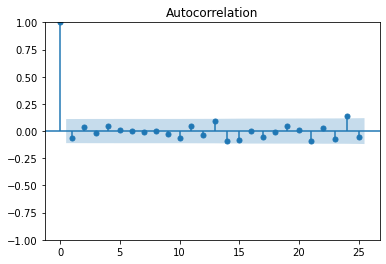

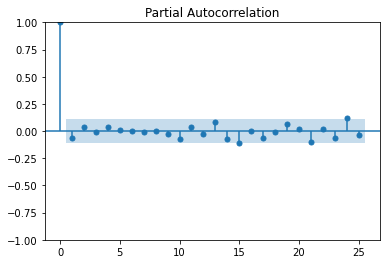

In [128]:
acf = plot_acf(trades_df_train_diff)
pacf = plot_pacf(trades_df_train_diff)

# ADF Test for Modified Data

In [129]:
adf_test = adfuller(trades_df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 2.0227953833793158e-30


# Fit ARIMA Model

In [130]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(trades_df_train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  split   No. Observations:                  314
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1240.026
Date:                Thu, 30 Mar 2023   AIC                           2486.051
Time:                        14:30:30   BIC                           2497.290
Sample:                             0   HQIC                          2490.543
                                - 314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0625      0.068     -0.914      0.361      -0.196       0.072
ar.L2          0.0380      0.067      0.564      0.573      -0.094       0.170
sigma2       161.6772      4.931     32.787      0.0

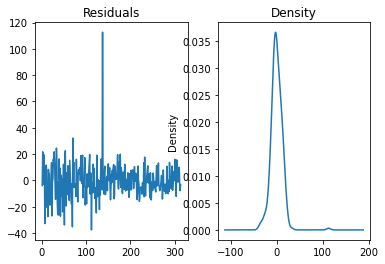

In [131]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [132]:
import pmdarima as pm
auto_arima = pm.auto_arima(trades_df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

<AxesSubplot:>

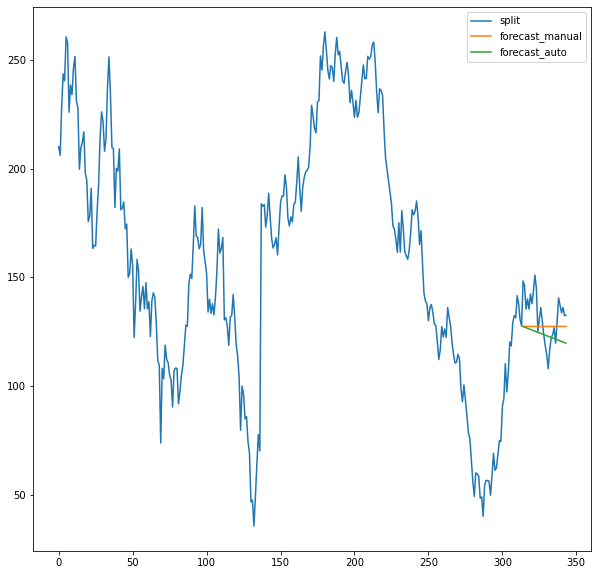

In [133]:
forecast_test_manual = model_fit.forecast(len(trades_df_test))
trades_df['forecast_manual'] = [None]*len(trades_df_train) + list(forecast_test_manual)
forecast_test_auto = auto_arima.predict(n_periods=len(trades_df_test))
trades_df['forecast_auto'] = [None]*len(trades_df_train) + list(forecast_test_auto)
trades_df.plot(figsize=(10, 10))